# ALeRCE classes

https://github.com/ZwickyTransientFacility/ztf-avro-alert

1. **AGN:** Active Galactic Nuclei
1. **Blazar:** Blazar
1. **CV/Nova:** Cataclysmic Variable Star/Nova
1. **Ceph:** Cepheid Variable Star
1. **DSCT:** Delta Scuti Star
1. **EA:** Eclipsing Algol
1. **EB/EW:** Eclipsing Binaries/Eclipsing W Ursa Majoris
1. **LPV:** Long Period Variable
1. **Periodic-Other:** Periodic-Other
1. **QSO:** Quasi-Stellar Object
1. **RRL:** RRLyrae Variable Star
1. **RSCVn:** RS Canum Venaticorum
1. **SLSN:** Super Luminous Supernova
1. **SNII:** Supernova II
1. **SNIIb:** Supernova IIb
1. **SNIIn:** Supernova IIn
1. **SNIa:** Supernova Ia
1. **SNIbc:** Supernova Ibc
1. **TDE:** Tidal disruption event (to remove)
1. **YSO:** Young Stellar Object
1. **ZZ:** ZZ Ceti Stars (to remove)

In [1]:
!pip install hdbscan
!pip install datashader
!pip install bokeh
!pip install holoviews
!pip install colorcet
!pip install joblib==0.17.0

     |████████████████████████████████| 4.7MB 7.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2301803 sha256=ce0190ea76bca7572508687bdde57dd4ed7568b6a2be707ebe93f8f071220125
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan
     |████████████████████████████████| 15.5MB 215kB/s 
     |████████████████████████████████| 1.6MB 51.0MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
     |████████████████████████████████| 102kB 12.6MB/s 
     |████████████████████████████████| 675kB 54.7MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-cp36-none-any.whl size=59430 sha256=6323ed1a9a1a54b2192fbad66e20ec5860a85e352cea52f45eb302755e2eed16
  Stored in directory: /roo

In [10]:
import numpy as np
import scipy.stats as stats
import cv2
import time
import hdbscan
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.neighbors import KernelDensity
import scipy.stats as st
#from scipy.spatial import euclidean
%matplotlib inline
# Dimension reduction and clustering libraries
import umap
#import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [6]:
def subset_df_columns(df, subset_cols):
    df_cols = list(df.columns)
    return df[[c for c in subset_cols if c in df_cols]]

def set_index(df, index_name):
    if not df.index.name is None and df.index.name==index_name:
        return df
    df_cols = list(df.columns)
    assert index_name in df_cols
    return df.set_index([index_name])

def df_to_float32(df):
    for c in df.columns:
        if df[c].dtype=='float64':
            df[c] = df[c].astype(np.float32)

In [11]:
#survey_name = 'alerceZTF_v5.1'
survey_name = '/content/Proyecto-IA/data/alerceZTF_v7.1' # use this dataset
load_root_dir = '/content'

import numpy as np
import pandas as pd

#survey_name = 'alerceZTFv5.1'
survey_name = 'alerceZTFv7.1' # use this dataset
survey_name = ''
df_index_names = {
    'oid':'oid', # object id
    'label':'classALeRCE', # object class name
    'ra':'ra',
    'dec':'dec',
    'band':'fid', # band
    'obs_day':'mjd', # days
    'obs':'magpsf_corr', # observations
    'obs_error':'sigmapsf_corr', # observation errors
}

### load files
#load_root_dir = f'../data/{survey_name}'
labels_df = pd.read_parquet(f'{load_root_dir}/labels.parquet')
print(f'labels_df - columns: {list(labels_df.columns)} - id: {labels_df.index.name}')


features_train_df = pd.read_parquet(f'{load_root_dir}/features_train.parquet')
print(f'features_train_df - id: {features_train_df.index.name}')
#for k,c in enumerate(list(features_train_df.columns)):
#    print(f'({k}) - {c}')

features_test_df = pd.read_parquet(f'{load_root_dir}/features_test.parquet')
#print(f'detections_df - columns: {list(features_test_df.columns)} - id: {features_test_df.index.name}')
#features_test_df = set_index(features_test_df, df_index_names['oid'])
#df_to_float32(features_test_df)

labels_df - columns: ['classALeRCE', 'ra', 'dec', 'period', 'source', 'id_source', 'class_source', 'separation_arcsec'] - id: oid
features_train_df - id: oid


OSError: ignored

Eliminamos ZZ y TDE

In [14]:
eliminate = labels_df['classALeRCE']!=('ZZ' )
labels_df.shape[0]-np.sum(eliminate)
features_train_df = features_train_df[eliminate]
labels_df = labels_df[eliminate]

4

In [ ]:
eliminate = labels_df['classALeRCE']!=('TDE')
labels_df.shape[0]-np.sum(eliminate)
features_train_df = features_train_df[eliminate]
labels_df = labels_df[eliminate]

Calculamos los elementos y porcentaje por clase del train dataset

In [19]:
a = labels_df['classALeRCE'].values
dic_a = {}
for i in set(a):
  dic_a[i] = [0, 0]
for i in a:
  dic_a[i][0]+=1

dic_a['ZZ'] = dic_a['TDE'] = [0, 0]
mapeo_a = {}
j = 1
for i in set(a):
  mapeo_a[i] = j
  j += 1
mapeo_array_a = [mapeo_a[i] for i in a]
for i in set(a):
  dic_a[i][1] = dic_a[i][0]*100/(len(labels_df)-6)
dic_a

{'AGN': [4248, 3.5861114159568452],
 'Blazar': [1234, 1.0417282220552606],
 'CV/Nova': [884, 0.7462623568045789],
 'Ceph': [613, 0.5174873582819082],
 'DSCT': [731, 0.6171015642807095],
 'EA': [6196, 5.230590003123496],
 'EB/EW': [31940, 26.96337067459078],
 'LPV': [14374, 12.134360991752281],
 'NLAGN': [5, 0.004220940932152596],
 'NLQSO': [74, 0.06246992579585841],
 'Periodic-Other': [399, 0.33683108638577713],
 'QSO': [20622, 17.408848780570164],
 'RRL': [32607, 27.526444194939938],
 'RSCVn': [995, 0.8399672454983665],
 'SLSN': [27, 0.022793081033624017],
 'SNII': [303, 0.25578902048844726],
 'SNIIb': [16, 0.013507010982888305],
 'SNIIn': [36, 0.03039077471149869],
 'SNIa': [1299, 1.0966004541732444],
 'SNIbc': [94, 0.07935368952446879],
 'TDE': [0, 0],
 'YSO': [1766, 1.4908363372362967],
 'ZZ': [0, 0]}

#Tratamiento de Datos

Eliminamos columnas llenas de NaN

In [17]:
features_train_df = features_train_df.dropna(how='all') # to delete full nans columns
print(features_train_df.info())
features_train_df[:20]

<class 'pandas.core.frame.DataFrame'>
Index: 118463 entries, ZTF17aaabgdt to ZTF20abfpkfh
Columns: 172 entries, Amplitude_1 to sgscore1
dtypes: float32(2), float64(170)
memory usage: 155.5+ MB
None


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,Eta_e_1,Eta_e_2,ExcessVar_1,ExcessVar_2,GP_DRW_sigma_1,GP_DRW_sigma_2,GP_DRW_tau_1,GP_DRW_tau_2,Gskew_1,Gskew_2,Harmonics_mag_1_1,Harmonics_mag_1_2,Harmonics_mag_2_1,Harmonics_mag_2_2,Harmonics_mag_3_1,Harmonics_mag_3_2,Harmonics_mag_4_1,Harmonics_mag_4_2,Harmonics_mag_5_1,Harmonics_mag_5_2,Harmonics_mag_6_1,Harmonics_mag_6_2,Harmonics_mag_7_1,Harmonics_mag_7_2,Harmonics_mse_1,Harmonics_mse_2,Harmonics_phase_2_1,Harmonics_phase_2_2,Harmonics_phase_3_1,Harmonics_phase_3_2,...,first_mag_1,first_mag_2,g-r_max,g-r_max_corr,g-r_mean,g-r_mean_corr,gal_b,gal_l,iqr_1,iqr_2,last_diffmaglim_before_fid_1,last_diffmaglim_before_fid_2,last_mjd_before_fid_1,last_mjd_before_fid_2,max_diffmaglim_after_fid_1,max_diffmaglim_after_fid_2,max_diffmaglim_before_fid_1,max_diffmaglim_before_fid_2,mean_mag_1,mean_mag_2,median_diffmaglim_after_fid_1,median_diffmaglim_after_fid_2,median_diffmaglim_before_fid_1,median_diffmaglim_before_fid_2,min_mag_1,min_mag_2,n_det_1,n_det_2,n_neg_1,n_neg_2,n_non_det_after_fid_1,n_non_det_after_fid_2,n_non_det_before_fid_1,n_non_det_before_fid_2,n_pos_1,n_pos_2,positive_fraction_1,positive_fraction_2,rb,sgscore1
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZTF17aaabgdt,0.164834,NaN,0.762395,NaN,1.0,NaN,0.285714,NaN,0.000000,NaN,6.766341,NaN,0.000061,NaN,0.015607,NaN,0.015514,NaN,-0.061406,NaN,2.719231,NaN,2.818967,NaN,3.728695,NaN,3.475463,NaN,2.947282,NaN,2.537885,NaN,2.476649,NaN,8.880320e-29,NaN,3.131992,NaN,4.344196,NaN,...,15.829703,NaN,NaN,NaN,NaN,NaN,-18.412434,203.437290,0.226245,NaN,NaN,NaN,NaN,NaN,20.467600,NaN,NaN,NaN,15.971543,NaN,19.380951,NaN,NaN,NaN,15.819786,NaN,7.0,NaN,4.0,NaN,10.0,NaN,0.0,NaN,3.0,NaN,0.428571,NaN,0.874286,0.942000
ZTF17aaadfsa,0.196974,0.185956,1.000000,1.000000,2.0,1.0,0.405405,0.470588,0.000000,0.000000,0.016721,0.000184,0.000079,0.000085,0.023445,0.022826,0.265007,0.660548,-0.246393,0.026846,0.220228,0.195069,0.092642,0.016051,0.093431,0.050824,0.072899,0.014385,0.068000,0.028424,0.036418,0.008859,0.034024,0.022044,2.642531e-04,2.684694e-04,5.221074,5.834820,2.882649,3.409096,...,17.281445,16.396856,0.628674,0.616542,0.606429,0.657136,22.876011,199.629128,0.303490,0.299521,NaN,NaN,NaN,NaN,20.778500,20.597099,NaN,NaN,17.185240,16.528104,19.951401,20.055201,NaN,NaN,16.957662,16.341120,37.0,34.0,22.0,17.0,33.0,63.0,0.0,0.0,15.0,17.0,0.405405,0.500000,0.822857,0.990833
ZTF17aaadxdb,0.253045,0.349630,1.000000,1.000000,1.0,1.0,0.500000,0.350000,0.000000,0.000000,0.101463,1.863679,0.000173,0.000251,0.034548,0.045570,0.200440,0.052149,-0.118506,-0.331246,0.236835,0.339457,0.046442,0.189562,0.011129,0.197622,0.004559,0.113607,0.008130,0.110303,0.002414,0.105912,0.002011,0.056646,3.928407e-04,3.269911e-03,0.075644,1.748785,5.885902,2.752293,...,14.264233,13.703113,1.767076,1.118140,0.772991,0.745624,-6.370139,163.533975,0.377040,0.396051,NaN,NaN,NaN,NaN,21.006399,20.775299,NaN,NaN,14.229380,13.483756,20.420399,20.098351,NaN,NaN,13.965243,12.847103,70.0,40.0,43.0,23.0,72.0,106.0,0.0,0.0,27.0,17.0,0.385714,0.425000,0.731429,0.973417
ZTF17aaadzlq,2.482923,1.983951,1.000000,1.000000,13.0,14.0,0.531646,0.469925,0.038298,0.049242,0.056143,0.004334,0.004246,0.003634,3.073063,2.336993,560.082886,691.973660,-4.043670,-2.075507,0.751513,1.297433,1.691417,2.872316,1.861833,2.639859,1.481500,2.150918,0.938548,1.538811,0.446548,0.766418,0.102387,0.236588,3.729645e-01,3.645578e-01,5.349881,0.847636,1.505798,1.151969,...,18.442327,16.068646,1.401412,1.443293,2.405003,2.283634,-8.430917,98.573952,1.250251,0.966956,NaN,NaN,NaN,NaN,20.979900,20.802299,NaN,NaN,19.104146,16.820512,19.768200,20.091301,NaN,NaN,13.879076,12.435783,237.0,266.0,202.0,241.0,35.0,30.0,0.0,0.0,35.0,25.0,0.147679,0.093985,0.828571,0.939375
ZTF17aaaenfy,0.487668,0.455345,1.000000,1.000000,1.0,1.0,0.344444,0.318182,0.000000,0.000000,0.181913,0.258110,0.000351,0.000338,

Reemplazando NAN por media de la columna

In [20]:
for i in features_train_df.columns:
  mean_i = np.mean(np.nan_to_num(features_train_df[i]))
  features_train_df[i] = np.nan_to_num(features_train_df[i], nan = mean_i)

Realizamos una normalizacion mediante Quantile Transformer, para lueg realizar un PCA con 90 caracteristicas

In [23]:
scaled_penguin_data = QuantileTransformer().fit_transform(features_train_df)
t_1 = time.time()
x_centered = (scaled_penguin_data - scaled_penguin_data.mean(axis=0))/scaled_penguin_data.std(axis=0)
scatter_matrix = np.dot(x_centered.transpose(), x_centered)
eigen_values, eigen_vectors = np.linalg.eig(scatter_matrix)
n_components = 90
V = eigen_vectors[:,:n_components]
pc_data = x_centered.dot(V)
t_2 = time.time()
print(t_2-t_1)

0.5792033672332764


Realizamos la separacion entre train y test

In [24]:
msk = np.random.rand(labels_df.shape[0]) < (70/100.)
X_train, X_test = pc_data[msk], pc_data[~msk]
Y_train, Y_test = labels_df[msk], labels_df[~msk]

Calculamos los elementos y porcentaje por clase en la division test

In [25]:
a = Y_test['classALeRCE'].values
dic = {}
for i in set(a):
  dic[i] = 0
for i in a:
  dic[i]+=1
mapeo = {}
j = 1
for i in set(a):
  mapeo[i] = j
  j += 1
mapeo_array_test = [mapeo[i] for i in a]

Calculamos los elementos y porcentaje por clase en la division train

In [26]:
a = Y_train['classALeRCE'].values
dic = {}
for i in set(a):
  dic[i] = 0
for i in a:
  dic[i]+=1
mapeo = {}
j = 1
for i in set(a):
  mapeo[i] = j
  j += 1
mapeo_array_train = [mapeo[i] for i in a]

#UMAP

Realizamos entonces el algoritmo de UMAP sobre todo el data set

In [27]:
t_1 = time.time()
standard_embedding = umap.UMAP(n_neighbors=25,
                     min_dist=0.0,
#                     metric='correlation',
                     n_components = 2,
                     random_state=42,
#                     n_epochs = 100
                     ).fit_transform(pc_data)
t_2 = time.time()
print(t_2-t_1)
plt.figure(figsize=(10,10))
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mapeo_array_a, s=0.1, cmap='Spectral')

269.80868887901306


Realizamos entonces el algoritmo de UMAP sobre todo el train data set

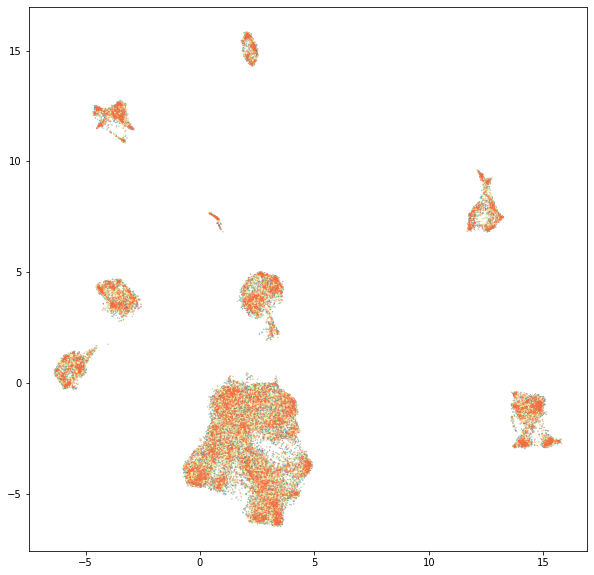

In [28]:
standard_embedding_train = umap.UMAP(n_neighbors=25,
                     min_dist=0.0,
#                     metric='correlation',
                     n_components = 2,
                     random_state=42,
#                     n_epochs = 100
                     ).fit_transform(X_train)
plt.figure(figsize=(10,10))
plt.scatter(standard_embedding_train[:, 0], standard_embedding_train[:, 1], c=mapeo_array_train, s=0.1, cmap='Spectral')

Realizamos entonces el algoritmo de UMAP sobre todo el test data set

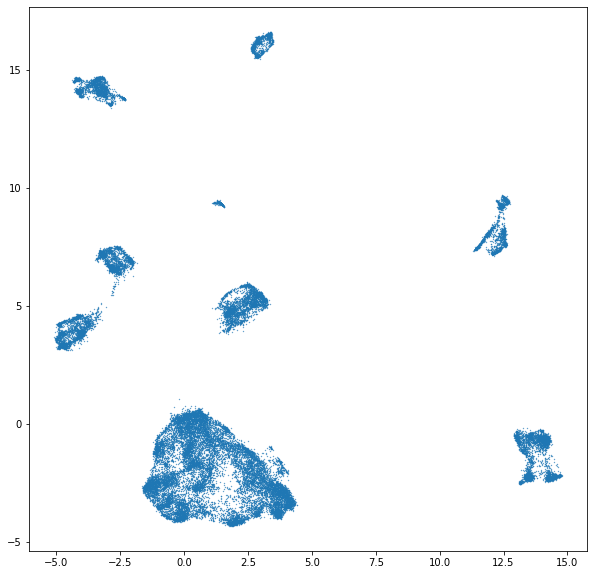

In [29]:
standard_embedding_test = umap.UMAP(n_neighbors=25,
                     min_dist=0.0,
#                     metric='correlation',
                     n_components = 2,
                     random_state=42,
#                     n_epochs = 100
                     ).fit_transform(X_test)
plt.figure(figsize=(10,10))
plt.scatter(standard_embedding_test[:, 0], standard_embedding_test[:, 1], s=0.1, cmap='Spectral')#, c=mapeo_array_test)

In [ ]:
labels_train = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(sekkk)

In [ ]:
labels_test = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(standard_embedding_test)

In [ ]:
clustered_train = (labels_train >= 0)
plt.figure(figsize=(8,8))
plt.scatter(sekkk[~clustered_train, 0],
            sekkk[~clustered_train, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5,
            label = 'None')
plt.scatter(sekkk[clustered_train, 0],
            sekkk[clustered_train, 1],
            c=labels_train[clustered_train],
            s=0.1,
#            label = kkk2_l_df['classALeRCE'].values[clustered_train].to,
            cmap='Spectral');
plt.legend()



In [ ]:
a = kkk2_l_df['classALeRCE'].values[~clustered_train]
dic = {}
for i in set(a):
  dic[i] = 0
for i in a:
  dic[i]+=1
mapeo = {}
j = 1
for i in set(a):
  mapeo[i] = j
  j += 1
mapeo_array_train = [mapeo[i] for i in a]

In [ ]:
clustered_test = (labels_test >= 0)
plt.figure(figsize=(10,10))
plt.scatter(standard_embedding_test[~clustered_test, 0],
            standard_embedding_test[~clustered_test, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding_test[clustered_test, 0],
            standard_embedding_test[clustered_test, 1],
            c=labels_test[clustered_test],
            s=0.1,
            cmap='Spectral');

#KDE Gaussiano

Realizamos un KDE gaussiano sobre el resultado de UMAP del train data set

In [31]:
X = standard_embedding_train
# Extract x and y
x = X[:, 0]
y = X[:, 1]
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

-8.581118965148926 18.022325897216795 -8.697504901885987 18.07640972137451


In [32]:
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel_train = st.gaussian_kde(values)
f = np.reshape(kernel_train(positions).T, xx.shape)

Text(0.5, 1.0, '2D Gaussian Kernel density estimation')

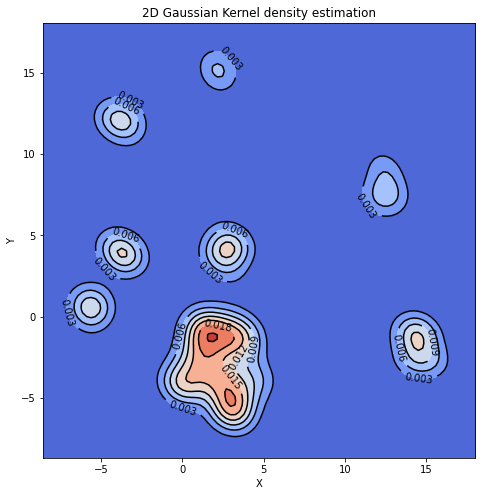

In [33]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')

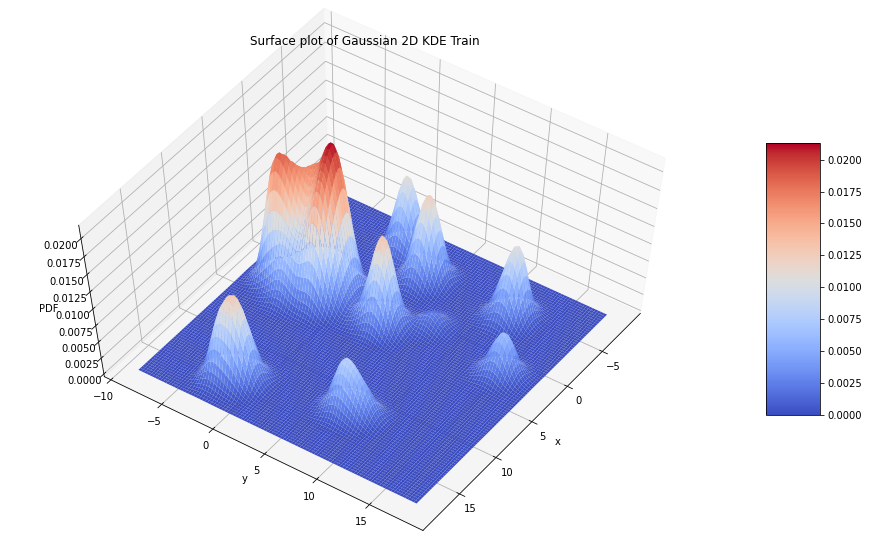

In [34]:
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE Train')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)

Realizamos un KDE gaussiano sobre el resultado de UMAP del test data set

In [ ]:
X = standard_embedding_test
# Extract x and y
x = X[:, 0]
y = X[:, 1]
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

In [36]:
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel_test = st.gaussian_kde(values)
f = np.reshape(kernel_test(positions).T, xx.shape)

Text(0.5, 1.0, '2D Gaussian Kernel density estimation')

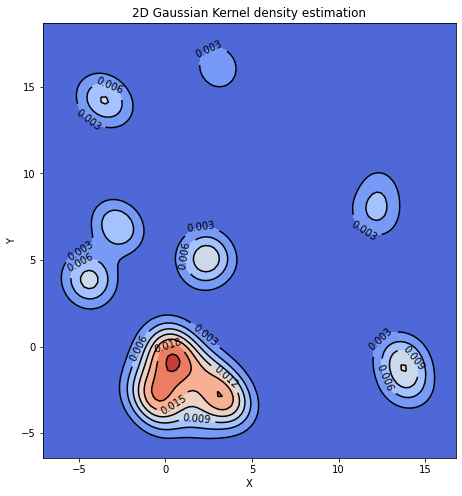

In [37]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')

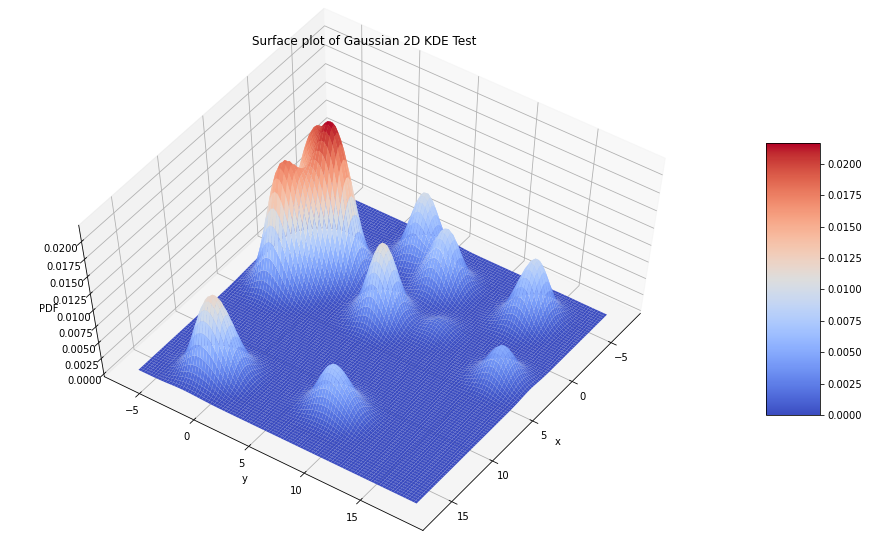

In [38]:
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE Test')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)

Realizamos un KDE gaussiano sobre el resultado de UMAP del data set completo, para luego calcular la divergencia KL

In [39]:
X = standard_embedding
x = X[:, 0]
y = X[:, 1]
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

-9.031331157684326 17.291184997558595 -8.05970811843872 18.52050018310547


In [43]:
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
t_1 = time.time()
f = np.reshape(abs((kernel_train(positions)-kernel_test(positions))).T, xx.shape)
t_2 = time.time()
print(t_2-t_1)

30.56681489944458


Text(0.5, 1.0, '2D Gaussian Kernel density estimation')

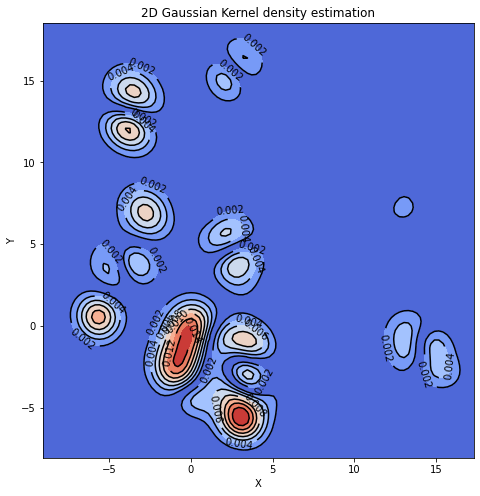

In [44]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')

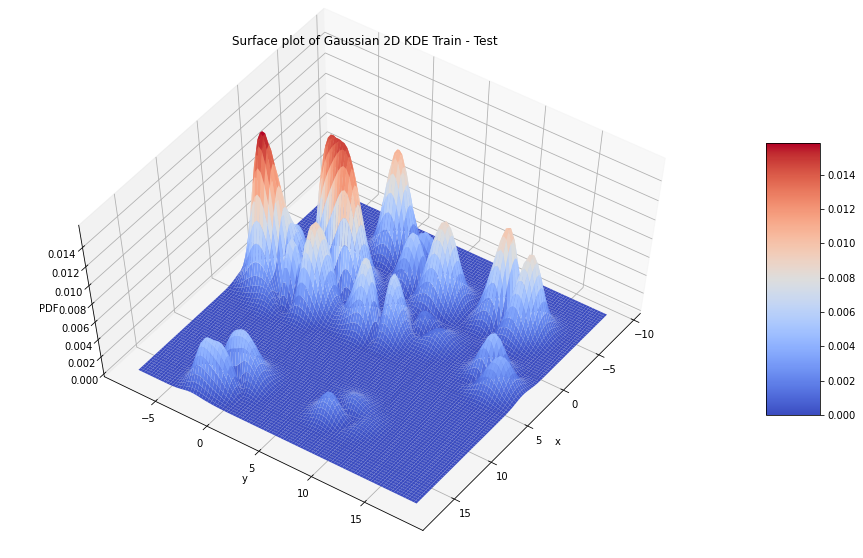

In [45]:
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE Train - Test')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)

#KL Divergence

In [46]:
def kl_divergence(p, q):
    return np.where(p != 0, p * np.log(p / q), 0)

Calculamos sobre todos los datos resultantes del UMAP sobre todo el dataset, el correspondiente valor de la divergencia kl, para luego graficarla.

In [76]:
t_1 = time.time()
a = kl_divergence(kernel_train(standard_embedding.T), kernel_test(standard_embedding.T))
t_2 = time.time()
print(t_2-t_1)

362.0033326148987


In [1]:
aa = np.reshape(kl_divergence(kernel_train(position), kernel_test(position)), xx.shape)

NameError: ignored

In [ ]:
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, aa, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE Train - Test')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)

Probamos un valor de divergencia, tal que obtengamos 100 valores, los cuales seran los peor clasificados

In [138]:
np.sum(a>0.00838)

10000

Luego creamos los nuevos dataset, agragando una columna llamada "class", donde 0 significa no clasificado, y 1 bien clasificado

In [139]:
i = 0.00838
b = a>i
c = a<i

In [140]:
kk = scaled_penguin_data[b]
kk = pd.DataFrame(kk, None, features_train_df.columns)
kk.shape

(10000, 172)

In [141]:
kk_l = labels_df.to_numpy()[b]
kk_l = pd.DataFrame(kk_l, None, labels_df.columns)
kk_l.shape

(10000, 8)

In [ ]:
kk_2 = scaled_penguin_data[c]
kk_2 = pd.DataFrame(kk_2, None, features_train_df.columns)
kk_2.shape

In [143]:
kk_l_2 = labels_df.to_numpy()[c]
kk_l_2 = pd.DataFrame(kk_l_2, None, labels_df.columns)
kk_l_2.shape

(108463, 8)

In [144]:
kk['class'] = [0]*len(kk)
kk_2['class'] = [1]*len(kk_2)

In [145]:
c = np.concatenate((kk.to_numpy(), kk_2.to_numpy()), axis=0)
c_df = pd.DataFrame(c, None, kk.columns)
c_df.shape

(118463, 173)

In [146]:
i = 5
indices = list(range(i))
indices.append(-1)
c_menos_df = c_df.to_numpy()
c_menos_df = c_menos_df[:, indices]
c_menos_df = pd.DataFrame(c_menos_df, None, c_df.columns[indices])
c_menos_df.shape

(118463, 6)

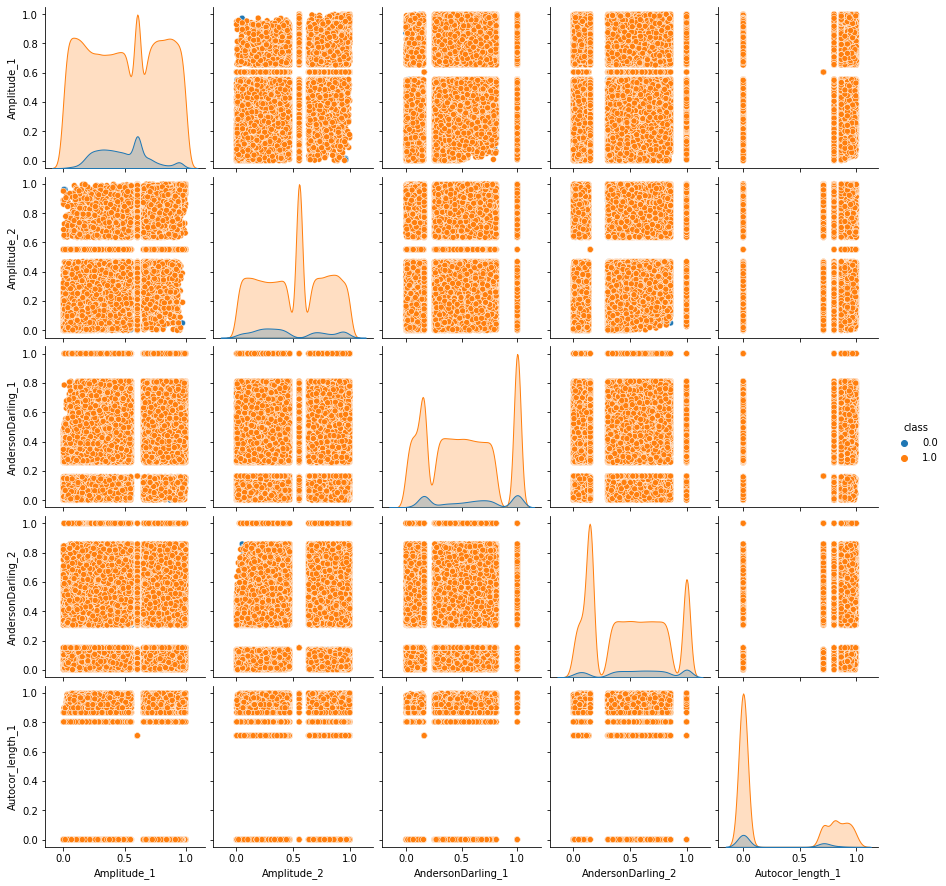

In [147]:
sns.pairplot(c_menos_df, diag_kind='kde', hue='class')

In [148]:
i = 5
indices = list(range(i))
c_menos_df = kk.to_numpy()
c_menos_df = c_menos_df[:, indices]
c_menos_df = pd.DataFrame(c_menos_df, None, c_df.columns[indices])
c_menos_df.shape

(10000, 5)

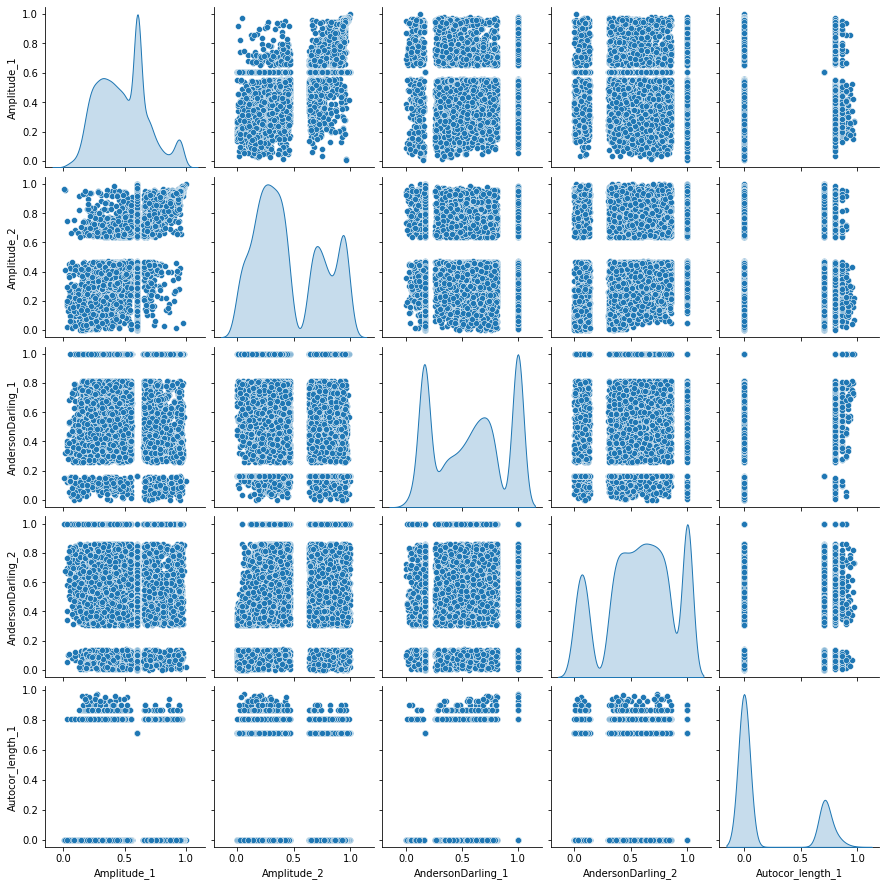

In [150]:
sns.pairplot(c_menos_df, diag_kind='kde')